# Signal processing

## 1. Load libraries

In [16]:
# Core 
import io

# Data Science
import numpy as np
import scipy 
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from hypyp.ext.mpl3d import glm
from hypyp.ext.mpl3d.mesh import Mesh
from hypyp.ext.mpl3d.camera import Camera

# MNE 
import mne

# HyPyP
from hypyp import prep 
from hypyp import analyses
from hypyp import stats
from hypyp import viz
from hypyp import utils

# From Mother-InfantEEG_complete notebook
import os
from copy import copy
from collections import OrderedDict
from mne.datasets import eegbci
from mne import Epochs, pick_types, find_events, pick_types, set_eeg_reference

# other
from copy import copy
import re 
import rise

## 2. Load preprocessed data

### Info
Each participant has five files (unless they did not complete the paradigm) containing hyper-epochs. These hyper-epochs consist of 2 seconds of clean, artifact-free data from both the mother AND the infant. Each file is a different stage of the study, i.e. free play, still face 1, free play, still face 2, reunion

In [17]:
# Identify the channels corresponding to the mother and child
def identify_person(dyad_data):
    r_i = re.compile(".*_Baby$")
    r_m = re.compile(".*_Mom$")
    infant_channels = [chan for chan in list(filter(r_i.match, dyad_data.info["ch_names"]))]
    mother_channels = [chan for chan in list(filter(r_m.match, dyad_data.info["ch_names"]))]

    return infant_channels, mother_channels


# Create and save mother and infant data in two separate files
def separate_files(dyad_path, i_channels, m_channels):
    dyad_data = mne.io.read_raw_edf(dyad_path, preload = False, stim_channel = 'auto', verbose = False)
    idx = re.findall(r'\d+', str(dyad_path))[0]
    cond = re.findall('-[0-5]-', str(dyad_path))[0]
    infant_path = f"Infant{idx}_{cond[1]}.fif"
    mother_path = f"Mother{idx}_{cond[1]}.fif"
    infant_file = dyad_data.save(infant_path, i_channels, overwrite = True)
    mother_file = dyad_data.save(mother_path, m_channels, overwrite = True)
    return infant_file, mother_file, infant_path, mother_path


# Rename channels: delete empty electrodes and remove _Baby and _Mom from channel names
# Takes as input separated infant and mother files
def rename_channel_names(data, baby):
    #old_channels = list(filter(lambda x: "EMPTY" not in x, data.info["ch_names"]))
    old_channels = list(data.info["ch_names"])
    if baby is True:
        new_channels_baby = [chan[:-5] if chan[-5:] == "_Baby"else chan for chan in old_channels]
        old_to_new_names = {}
        for old, new in zip(old_channels, new_channels_baby):
            old_to_new_names[old] = new
        data.rename_channels(mapping = old_to_new_names)
    else:
        new_channels_mom = [chan[:-4] if chan[-4:] == "_Mom" else chan for chan in old_channels]
        old_to_new_names = {}
        for old, new in zip(old_channels, new_channels_mom):
            old_to_new_names[old] = new

        data.rename_channels(mapping = old_to_new_names)
    
    return data

# Combine the functions above to read the data 
def read_data(dyad_path):
    # Read the dyad data 
    print(dyad_path)
    dyad_data = mne.io.read_raw_edf(dyad_path, preload = False, stim_channel = 'auto', verbose = False)
    
    # Identify channels belonging to the infant and mother
    infant_channels, mother_channels = identify_person(dyad_data)

    # Separate the files based on the channels 
    infant_file, mother_file, infant_path, mother_path = separate_files(dyad_path, infant_channels, mother_channels)

    # Read the newly created files 
    infant_data = mne.io.read_raw(infant_path, preload = True, verbose = False)
    mother_data = mne.io.read_raw(mother_path, preload = True, verbose = False)

    # Rename the channels (remove _Baby and _Mom from channel names)
    rename_channel_names(infant_data, True)
    rename_channel_names(mother_data, False)

    # Set montage
    infant_data.set_montage('biosemi64') 
    mother_data.set_montage('biosemi64') 

    return infant_file, mother_file, dyad_data, infant_data, mother_data


## 3. Convert to epochs

In [18]:
# Epoch the data
def get_epochs(rawBaby, rawMom):
    # Define the duration of the epoch (in seconds)
    epoch_duration = rawBaby.times[-1] - rawBaby.times[0]  # Duration of the continuous data

    # Create the long epoch
    rawBabyEpochs = mne.make_fixed_length_epochs(rawBaby, duration=epoch_duration, preload=True)
    rawMomEpochs = mne.make_fixed_length_epochs(rawMom, duration=epoch_duration, preload=True)

    # # Downsample the data to reduce the computation time. Using a 512 Hz rate or higher should be enough 
    # # for most high frequency analyses (Turk et al., 2022)
    # print('Original sampling rate:', rawBabyEpochs.info['sfreq'], 'Hz')
    rawBabyEpochs.resample(250)
    rawMomEpochs.resample(250)

    rawBabyEpochs.filter(1, 15)
    rawMomEpochs.filter(1, 15)
    # print('New sampling rate:', rawBabyEpochs.info['sfreq'], 'Hz')
    return rawBabyEpochs, rawMomEpochs


Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 115 events and 4096 original time points ...
0 bad epochs dropped
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 115 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_24710/2071268851.py:16: RuntimeWarning: filter_length (825) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  rawBabyEpochs.filter(1, 15)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Done 7360 out of 7360 | elapsed:    2.5s finished
/tmp/ipykernel_24710/2071268851.py:17: RuntimeWarning: filter_length (825) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  rawMomEpochs.filter(1, 15)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=1)]: Done 7360 out of 7360 | elapsed:    2.4s finished


Averaging across epochs...


/home/agata/Desktop/thesis/.venv/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


## 4. Set parameters
Define the frequency bands of interest and the sampling rate<br><br>
Passbands for the adult data: 1. theta [4–7 Hz] 2) alpha [8–12 Hz] 3) beta [13–30 Hz] 4) gamma [31–48 Hz].<br><br> 
Because of the differences in frequency bands between adult and infant data, the following settings are used for the infant data: 1) theta [3–5 Hz] 2) alpha [6–9 Hz] and 3) beta [13–30 Hz] 4) gamma [31–48 Hz]. <br><br>
Source: https://www.sciencedirect.com/science/article/pii/S1878929322000482

In [7]:
def set_parameters():
    # overlap: theta - 4-5, alpha - 8-9
    freq_bands = {'Theta-Baby': [3, 5], 
                'Theta-Mom': [4, 7],
                'Alpha-Baby': [6, 9], 
                'Alpha-Mom': [8, 12]} 
                
    full_freq = { 'full_frq': [3, 12]}

    return freq_bands

freq_bands = set_parameters()

## 5. PLV 
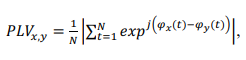<br><br>

<br><br>
pair_connectivity(data: Union[list, np.ndarray], sampling_rate: int, frequencies: Union[dict, list], mode: str,
                      epochs_average: bool = True) -> np.ndarray:

In [8]:
def compute_plv(rawBabyEpochs, rawMomEpochs, freq_bands):
    data_inter = np.array([rawBabyEpochs, rawMomEpochs])
    sampling_rate=rawBabyEpochs.info["sfreq"]
    complex_signal = analyses.compute_freq_bands(data_inter, sampling_rate, freq_bands)
    plv = analyses.compute_sync(complex_signal, mode='plv')
    return plv

# plv = compute_plv(rawBabyEpochs, rawMomEpochs, freq_bands)

In [9]:
# The diagonal elements of the matrix correspond to the PLV of each channel with itself and are always equal to 1
# Let's remove them 
def clean_plvmatrix(plv):
    plv_clean = plv.copy()
    for i in range(plv.shape[0]):
        plv_clean[i] -= np.diag(np.diag(plv_clean[i]))
    return plv_clean

In [10]:
def get_plv_perband(rawBabyEpochs, plv_clean):
    n_ch = len(rawBabyEpochs.info['ch_names'])
    theta_baby, theta_mom, alpha_baby, alpha_mom = plv_clean[:, 0:n_ch, n_ch:2*n_ch]
    return theta_baby, theta_mom, alpha_baby, alpha_mom

## Process the data for one dyad

In [11]:
import mne_connectivity

dataPath = os.path.join(os.getcwd(), "dyad_data/preprocessed_data") # path to the folder with all participants 
allDyadsDir = os.listdir(dataPath) # folder with all participants 
freq_bands = set_parameters()
dyadPath = os.path.join(dataPath, allDyadsDir[0]) 
dyadDir = sorted(os.listdir(dyadPath))

# path per each stage (free play 1, still face 1, etc.)
stagePath = os.path.join(dyadPath, dyadDir[3]) 
# create separate infant and mother files and two raw objects 
infant_file, mother_file, dyad_data, rawBaby, rawMom = read_data(stagePath) 
# epoch the data 
rawBabyEpochs, rawMomEpochs = get_epochs(rawBaby, rawMom)
# compute plv between the mother and child
plv = compute_plv(rawBabyEpochs, rawMomEpochs, freq_bands)
# delete the diagonal
plv_clean = clean_plvmatrix(plv)
# data per each freq band 
theta_baby, theta_mom, alpha_baby, alpha_mom = get_plv_perband(rawBabyEpochs, plv_clean)

/home/agata/Desktop/thesis/dyad_data/preprocessed_data/T036_StillFace_EDF_Ns/T036_StillFace-4-edf.edf
Overwriting existing file.
Writing /home/agata/Desktop/thesis/Infant036_4.fif


/tmp/ipykernel_24710/3043717431.py:18: RuntimeWarning: This filename (/home/agata/Desktop/thesis/Infant036_4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  infant_file = dyad_data.save(infant_path, i_channels, overwrite = True)


Closing /home/agata/Desktop/thesis/Infant036_4.fif
[done]
Overwriting existing file.
Writing /home/agata/Desktop/thesis/Mother036_4.fif


/tmp/ipykernel_24710/3043717431.py:19: RuntimeWarning: This filename (/home/agata/Desktop/thesis/Mother036_4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mother_file = dyad_data.save(mother_path, m_channels, overwrite = True)


Closing /home/agata/Desktop/thesis/Mother036_4.fif
[done]


/tmp/ipykernel_24710/3043717431.py:57: RuntimeWarning: This filename (Infant036_4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  infant_data = mne.io.read_raw(infant_path, preload = True, verbose = False)
/tmp/ipykernel_24710/3043717431.py:58: RuntimeWarning: This filename (Mother036_4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mother_data = mne.io.read_raw(mother_path, preload = True, verbose = False)


Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 471039 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 471039 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.7s finished


## Visualize inter-brain connectivity

In [12]:
print(rawBaby.get_data().shape)

(64, 471040)


In [13]:
matrix = theta_baby.copy()

# Compute the median and standard error by column
median = np.median(matrix, axis=0)
std_error = np.std(matrix, axis=0) / np.sqrt(matrix.shape[0])

# Find the maximum median and maximum standard error
max_median = np.max(median)
max_std_error = np.max(std_error)

# Print the results
print("Maximum median by column:", max_median)
print("Maximum standard error by column:", max_std_error)

print(max_median + max_std_error) 

Maximum median by column: 0.05590455639402328
Maximum standard error by column: 0.0030421564029473385
0.05894671279697062


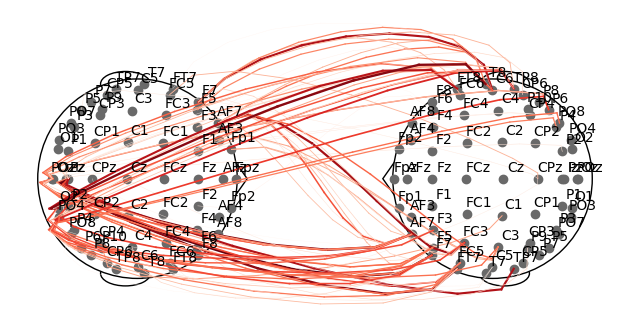

<AxesSubplot: >

In [14]:
# theta baby
viz.viz_2D_topomap_inter(rawBabyEpochs, rawMomEpochs, theta_baby, threshold = 'auto', steps=10, lab=True)

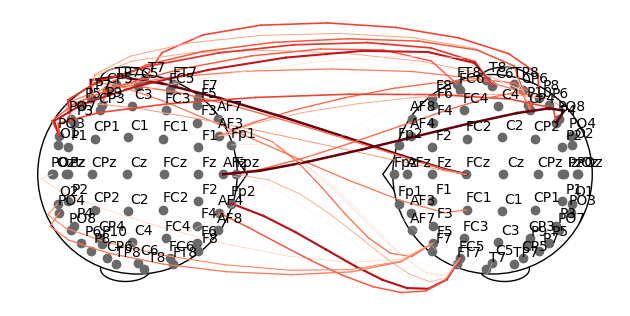

<AxesSubplot: >

In [14]:
# theta mom
viz.viz_2D_topomap_inter(rawBabyEpochs, rawMomEpochs, theta_mom, threshold = 'auto', steps=10, lab=True)

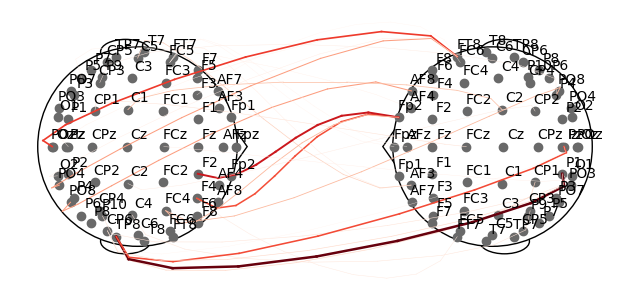

<AxesSubplot: >

In [15]:
# alpha baby
viz.viz_2D_topomap_inter(rawBabyEpochs, rawMomEpochs, alpha_baby, threshold = 'auto', steps=10, lab=True)

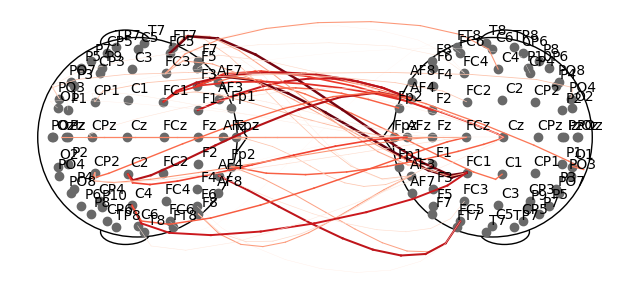

<AxesSubplot: >

In [16]:
# alpha mom
viz.viz_2D_topomap_inter(rawBabyEpochs, rawMomEpochs, alpha_mom, threshold = 'auto', steps=10, lab=True)

In [3]:
# Opening JSON file
import json
f = open('results.json')
  
# returns JSON object as 
# a dictionary
results = json.load(f)
  
# Iterating through the json
# list
fp1 = []
sf1 = []
fp2 = []
sf2 = []
reunion = []

all_stages = [fp1, sf1, fp2, sf2, reunion]
for part, data in results.items():
    for stage, bands in data.items():
        all_stages[int(stage)-1].append(bands)

print(fp1) 
print(fp2)
    
# Closing file
f.close()

[{'theta_baby': [[0.2549223756579535, 0.24349926614531026, 0.25673493661389707, 0.27028888645556326, 0.2777633271183152, 0.27554612603362, 0.2535862294312076, 0.24844049727366777, 0.25873600502382355, 0.2641345365978481, 0.2829187497454242, 0.28527796915127906, 0.255403902326988, 0.2756040652129799, 0.27501654086001365, 0.2771546984738877, 0.27983594194574446, 0.24133141320359205, 0.2641595004629489, 0.27704943786816477, 0.2713218498905701, 0.2600205051548062, 0.26869196780655463, 0.2502377322227368, 0.26213638424581504, 0.28596784008714365, 0.2644963900683328, 0.24973199680543295, 0.2668115391986021, 0.2597515883421901, 0.24664385828448426, 0.28695645628054856, 0.2641186365431664, 0.26666757490790993, 0.2563808569693773, 0.25882087259831804, 0.2660428744170023, 0.26725942277711995, 0.2699531314738724, 0.2835123257819677, 0.2695524870758982, 0.2766162633250848, 0.24294853111657805, 0.2645312568768193, 0.31581318203772657, 0.2934868681317918, 0.2872369752542664, 0.29601276068162147, 0.2

## Statistical analyses
### Comparing Inter-brain connectivity values to random signal¶
No a priori connectivity between channels is considered between the two participants

In Alpha_Low band for example (see above), create another time two fake groups with twice the 'participant1' and twice the 'participant2'

In [4]:
fp1_theta = np.array([np.mean(part['theta_baby']) for part in fp1])
sf1_theta = np.array([np.mean(part['theta_baby']) for part in sf1])
fp2_theta = np.array([np.mean(part['theta_baby']) for part in fp2])
sf2_theta = np.array([np.mean(part['theta_baby']) for part in sf2])


# Perform the Fisher z-transform
z_fp1_theta = np.arctanh(fp1_theta)
z_sf1_theta = np.arctanh(sf1_theta)
z_fp2_theta = np.arctanh(fp2_theta)
z_sf2_theta = np.arctanh(sf2_theta)

print(sf1_theta)
print(z_sf1_theta)

[0.27579605 0.27937242 0.29541988 0.28600861]
[0.28312629 0.28700123 0.30449405 0.29421385]


In [24]:
fp1_theta = np.array([part['theta_baby'] for part in fp1])
sf1_theta = np.array([part['theta_baby'] for part in sf1])
fp2_theta = np.array([part['theta_baby'] for part in fp2])
sf2_theta = np.array([part['theta_baby'] for part in sf2])
data = [fp1_theta, sf1_theta, fp2_theta, sf2_theta] 

print(len(fp1))

statscondCluster = stats.statscondCluster(data=data,
                                          freqs_mean=freq_bands['Theta-Baby'],
                                          ch_con_freq=None,
                                          tail=1,
                                          n_permutations=1000,
                                          alpha=0.05)

4
Using a threshold of 3.490295
stat_fun(H1): min=0.003918 max=10.956174
Running initial clustering …
Found 120 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

## Plot significant sensors

In [18]:
viz.plot_significant_sensors(
    T_obs_plot=statscondCluster.F_obs_plot, epochs=rawBabyEpochs)

TypeError: plot_topomap() got an unexpected keyword argument 'vmin'

In [23]:
print(statscondCluster.F_obs_plot)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
